In [1]:
%load_ext autoreload
%autoreload 2

# SpikeInterface pipeline for Mease Lab - CED

In [2]:
from pathlib import Path
import numpy as np
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

from mease_lab_to_nwb.convert_ced.cednwbconverter import quick_write
%matplotlib notebook

## 1) Load CED recording, set channel locations, compute LFP, and inspect signals

In [3]:
ced_file = Path('/home/luiz/storage/taufferconsulting/client_ben/project_heidelberg_gui/heidelberg_data/CED_example_data/M365/pt1 15 + mech.smrx')
# ced_file = Path('/Users/abuccino/Documents/Data/catalyst/heidelberg/ced/m365_pt1_590-1190secs-001.smrx')
# ced_file = Path('D:/CED_example_data/Other example/m365_pt1_590-1190secs-001.smrx')
probe_file = '../probe_files/cambridge_neurotech_H3.prb'
spikeinterface_folder = ced_file.parent
spikeinterface_folder.mkdir(parents=True, exist_ok=True)

In [4]:
# Automatically select Rhd channels
channel_info = se.CEDRecordingExtractor.get_all_channels_info(ced_file)

rhd_channels = []
for ch, info in channel_info.items():
    if "Rhd" in info["title"]:
        rhd_channels.append(ch)

In [5]:
recording = se.CEDRecordingExtractor(ced_file, smrx_channel_ids=rhd_channels)

# Load probe file to re-order channels and add location
recording = se.load_probe_file(recording, probe_file)

<IPython.core.display.Javascript object>


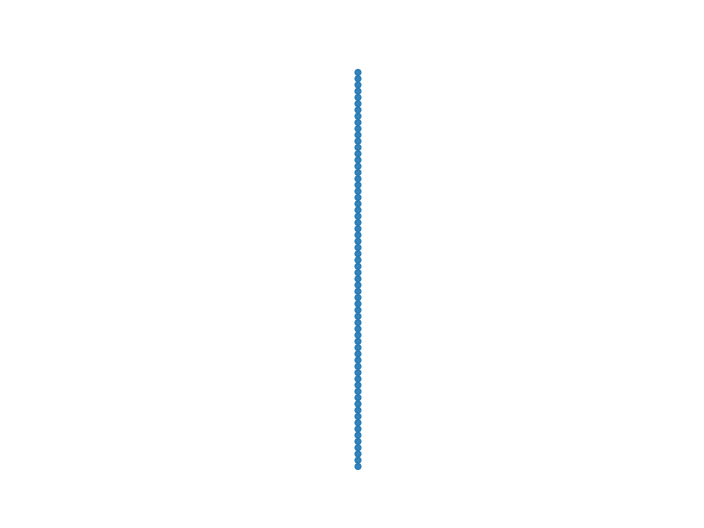

In [6]:
sw.plot_electrode_geometry(recording)

## Concatenate multiple recordings 

With the `MultiRecordingTimeExtractor`, you can easily concatenate the multiple recordings in time. The recordings must have the same channels and locations (e.g. same probe file).

In [7]:
# here we concatenate the same file as an example
recording_files = [ced_file, ced_file, ced_file]

recordings = []
for file in recording_files:
    # Automatically select Rhd channels
    channel_info = se.CEDRecordingExtractor.get_all_channels_info(file)

    rhd_channels = []
    for ch, info in channel_info.items():
        if "Rhd" in info["title"]:
            rhd_channels.append(ch)
    recording = se.CEDRecordingExtractor(ced_file, smrx_channel_ids=rhd_channels)
    recording = se.load_probe_file(recording, probe_file)
    recordings.append(recording)
# instantiate a MultiRecording object
multirecording = se.MultiRecordingTimeExtractor(recordings)

The `multirecording` is also a `RecordingExtractor` and it can be used for further processing. It contains `epoch` information about start and end of each recording.

In [8]:
for epoch_name in multirecording.get_epoch_names():
    print(multirecording.get_epoch_info(epoch_name))

{'start_frame': 0, 'end_frame': 124708908}
{'start_frame': 124708908, 'end_frame': 249417816}
{'start_frame': 249417816, 'end_frame': 374126724}


If you have separate files from different probes recorded using the same device, you can concatenate them in the channel dimension. You can add separate groups to the different recordings.

In [9]:
# here we concatenate the same recording as an example
multirec_group = se.MultiRecordingChannelExtractor([recording, recording], groups=[0, 1])

In [10]:
print(multirec_group.get_channel_groups())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Different groups can be spike sorted separately using the `grouping_property='group'` argument. The when spike sorting by group, the output units have a property called `group` with info about which group it's been found on.

**Note that MultiRecordingTimeExtractor and ChannelExtractor can be easily combined!**

In [11]:
print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

Num channels: 64
Sampling rate: 30030.030030030033
Duration (s): 4152.8066364


### Load LFP

In [12]:
lfp_channels = []
for ch, info in channel_info.items():
    if "LFP" in info["title"]:
        lfp_channels.append(ch)

In [13]:
recording_lfp = se.CEDRecordingExtractor(ced_file, smrx_channel_ids=lfp_channels)

In [14]:
print(f"Sampling frequency AP: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")      

Sampling frequency AP: 30030.030030030033
Sampling frequency LF: 30030.030030030033


### (Optional) Resample LFP

In [15]:
recording_lfp = st.preprocessing.resample(recording_lfp, resample_rate=1000)

/media/luiz/storage/Github/spiketoolkit/spiketoolkit/preprocessing/resample.py:28: UserWarning: Timestamps will be resampled uniformly. Non-uniform timestamps will be lost due to resampling.
  warn("Timestamps will be resampled uniformly. Non-uniform timestamps will be lost due to resampling.")


### Inspect signals

<IPython.core.display.Javascript object>


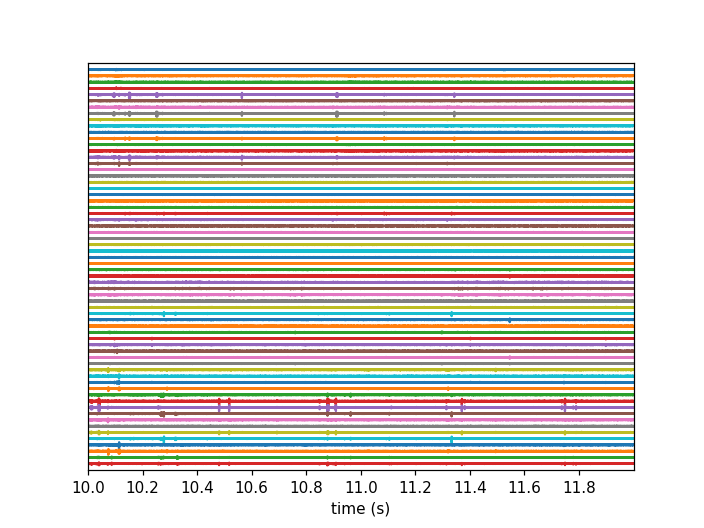

In [16]:
w_ts_ap = sw.plot_timeseries(recording, trange=[10, 12])

<IPython.core.display.Javascript object>


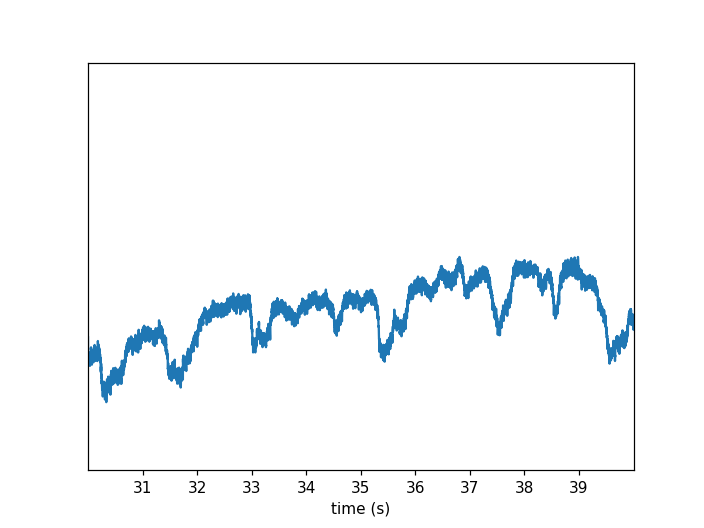

In [17]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[30, 40])

## 2) Pre-processing

In [18]:
apply_filter = False # the CED data appear to be already filtered
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [19]:
st.preprocessing.common_reference?

In [20]:
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording
    
if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)

In [21]:
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = True
nsec_stub = 30

if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(
        recording_lfp, 
        end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency())
    )
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

Original signal length: 124708908
Processed signal length: 900900


In [22]:
num_frames = recording_processed.get_num_frames()
print(num_frames)

900900


<IPython.core.display.Javascript object>


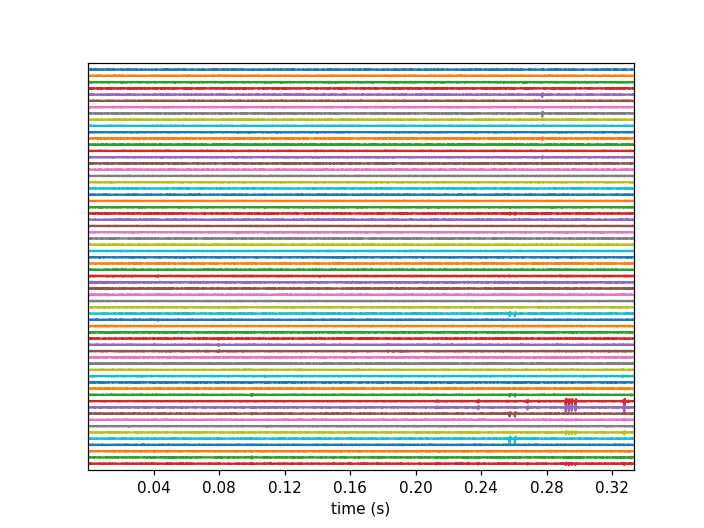

In [23]:
w_ts_ap = sw.plot_timeseries(recording_processed)

## 3) Run spike sorters

In [24]:
ss.installed_sorters()
# ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")

['herdingspikes', 'klusta']

In [25]:
sorter_list = [
    "herdingspikes",
#     "ironclust",
    "klusta"
]

In [26]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"\n\n{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    



herdingspikes params description:
{'ahpthr': 'Requires magnitude of spike rebound for acceptance',
 'amp_evaluation_time': 'Amplitude evaluation time (ms)',
 'clustering_alpha': 'Scalar for the waveform PC features when clustering.',
 'clustering_bandwidth': 'Meanshift bandwidth, average spatiel extent of spike '
                         'clusters (um)',
 'clustering_bin_seeding': 'Enable clustering bin seeding.',
 'clustering_min_bin_freq': 'Minimum spikes per bin for bin seeding.',
 'clustering_n_jobs': 'Number of cores to use for clustering.',
 'clustering_subset': 'Number of spikes used to build clusters. All by '
                      'default.',
 'decay_filtering': 'Experimental: Set to True at your risk',
 'detect_threshold': 'Detection threshold',
 'filter': 'Enable or disable filter',
 'filter_duplicates': 'Remove spike duplicates (based on spk_evaluation_time)',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'left_cutout_

In [27]:
# user-specific parameters
sorter_params = dict(
#     ironclust={'detect_threshold': 6}, 
    klusta={}, 
    herdingspikes={}
)

In [28]:
ss.run_sorters?

In [29]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    working_folder=spikeinterface_folder / 'ced_si_output',
    recording_dict_or_list=dict(rec0=recording_processed), 
    sorter_params=sorter_params,
    mode="overwrite", # change to "keep" to avoid repeating the spike sorting
    verbose=True,
)

# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 30030
# Localization On
# Number of recorded channels: 64
# Analysing frames: 900900; Seconds: 30.0
# Frames before spike in cutout: 9
# Frames after spike in cutout: 54
# tcuts: 39 84
# tInc: 100000
# Analysing frames from -39 to 100084  (0.0%)
# Analysing frames from 99961 to 200084  (11.1%)
# Analysing frames from 199961 to 300084  (22.2%)
# Analysing frames from 299961 to 400084  (33.3%)
# Analysing frames from 399961 to 500084  (44.4%)
# Analysing frames from 499961 to 600084  (55.5%)
# Analysing frames from 599961 to 700084  (66.6%)
# Analysing frames from 699961 to 800084  (77.7%)
# Analysing frames from 799961 to 900084  (88.8%)
# Analysing frames from 899961 to 900900  (99.9%)
# Detection completed, time taken: 0:08:44.361042
# Time per frame: 0:00:00.582041
# Time per sample: 0:00:00.009094
Loaded 2976 spikes.
Fitting dimensionality reduction using all spikes...
...projecti

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    1.9s remaining:    8.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.1s finished


Number of estimated units: 20
Saving to /home/luiz/storage/taufferconsulting/client_ben/project_heidelberg_gui/heidelberg_data/CED_example_data/M365/ced_si_output/rec0/herdingspikes/HS2_sorted.hdf5
herdingspikes run time 526.68s


Writing to binary .dat file: 100%|##########| 1/1 [00:24<00:00, 24.67s/it]


RUNNING SHELL SCRIPT: /home/luiz/storage/taufferconsulting/client_ben/project_heidelberg_gui/heidelberg_data/CED_example_data/M365/ced_si_output/rec0/klusta/run_klusta.sh
18:49:40 [I] creator:446          Using kwik file `/media/luiz/storage/taufferconsulting/client_ben/project_heidelberg_gui/heidelberg_data/CED_example_data/M365/ced_si_output/rec0/klusta/recording.kwik`.

18:49:40 [I] launch:206           Starting spike detection.

18:49:40 [I] launch:53            SpikeDetekt parameters:

18:49:40 [I] launch:55            chunk_overlap_seconds = 0.015

18:49:40 [I] launch:55            chunk_size_seconds = 3

18:49:40 [I] launch:55            connected_component_join_size = 1

18:49:40 [I] launch:55            detect_spikes = negative

18:49:40 [I] launch:55            dtype = int16

18:49:40 [I] launch:55            excerpt_size_seconds = 1

18:49:40 [I] launch:55            experiment_name = recording.kwik

18:49:40 [I] launch:55            extract_s_after = 32

18:49:40 [I] launch

18:50:53 [I] klustakwik Deleting cluster 7 (6 points): improves score by 5083.320020031184

18:50:53 [I] klustakwik Iteration 3F: 39 clusters, 1887 changed, score=-6260063.090541 (decreased by 14715.870497)

18:50:54 [I] klustakwik Deleting cluster 14 (2 points): improves score by 2658.0258754342794

18:50:54 [I] klustakwik Iteration 4F: 37 clusters, 932 changed, score=-6259504.895313 (decreased by -558.195229)

18:50:55 [I] klustakwik Deleting cluster 12 (12 points): improves score by 1635.5866033677012

18:50:55 [I] klustakwik Iteration 5F: 36 clusters, 649 changed, score=-6264656.597396 (decreased by 5151.702083)

18:50:57 [I] klustakwik Deleting cluster 25 (19 points): improves score by 1379.8617917774245

18:50:57 [I] klustakwik Iteration 6F: 35 clusters, 367 changed, score=-6269645.002042 (decreased by 4988.404647)

18:50:58 [I] klustakwik Deleting cluster 12 (32 points): improves score by 1246.2353376615793

18:50:58 [I] klustakwik Iteration 7F: 34 clusters, 312 changed, score=-

18:53:04 [I] klustakwik Iteration 60F: 29 clusters, 8 changed, score=-6285374.301928 (decreased by -1.108125)

18:53:05 [I] klustakwik Iteration 61F: 29 clusters, 8 changed, score=-6285377.196804 (decreased by 2.894876)

18:53:07 [I] klustakwik Iteration 62F: 29 clusters, 11 changed, score=-6285375.864803 (decreased by -1.332001)

18:53:08 [I] klustakwik Iteration 63F: 29 clusters, 11 changed, score=-6285374.638987 (decreased by -1.225815)

18:53:09 [I] klustakwik Iteration 64F: 29 clusters, 6 changed, score=-6285374.978792 (decreased by 0.339805)

18:53:10 [I] klustakwik Iteration 65F: 29 clusters, 3 changed, score=-6285375.564048 (decreased by 0.585256)

18:53:12 [I] klustakwik Iteration 66F: 29 clusters, 2 changed, score=-6285375.892255 (decreased by 0.328206)

18:53:13 [I] klustakwik Iteration 67F: 29 clusters, 1 changed, score=-6285376.335399 (decreased by 0.443145)

18:53:14 [I] klustakwik Iteration 68F: 29 clusters, 0 changed, score=-6285376.345229 (decreased by 0.009830)

18:53

18:57:52 [I] klustakwik Split into 32 clusters

18:57:54 [I] klustakwik Iteration 117F: 32 clusters, 18 changed, score=-6286765.675886 (decreased by 15.220153)

18:57:54 [W] klustakwik Cycle detected! Attempting to break out by splitting.

18:57:54 [I] klustakwik Trying to split clusters

18:58:17 [I] klustakwik Split into 33 clusters

18:58:18 [I] klustakwik Iteration 118F: 33 clusters, 38 changed, score=-6286116.377635 (decreased by -649.298251)

18:58:20 [I] klustakwik Iteration 119F: 33 clusters, 15 changed, score=-6286221.666340 (decreased by 105.288705)

18:58:21 [I] klustakwik Iteration 120F: 33 clusters, 18 changed, score=-6286354.937229 (decreased by 133.270889)

18:58:22 [I] klustakwik Iteration 121F: 33 clusters, 21 changed, score=-6286477.106627 (decreased by 122.169398)

18:58:24 [I] klustakwik Iteration 122F: 33 clusters, 14 changed, score=-6286551.923668 (decreased by 74.817041)

18:58:26 [I] klustakwik Iteration 123F: 33 clusters, 9 changed, score=-6286579.513692 (decre

The `sorting_outputs` is a dictionary with ("rec_name", "sorter_name") as keys.

In [30]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"{sorter} found {len(sorting.get_unit_ids())} units")

herdingspikes found 20 units
klusta found 31 units


### Split sorting output when concatenation is used

If you concatenated multiple recordings into a `MultiRecordingTimeExtractor`, you can split the sorting output using the epoch information and the `SubSortingExtractor`.

In [31]:
if isinstance(recording_processed, se.MultiRecordingTimeExtractor):
    sortings_split = []
    sorting_to_be_split = sorting_outputs[('rec0', 'ironclust')]

    for epoch_name in recording_processed.get_epoch_names():
        epoch_info = multirecording.get_epoch_info(epoch_name)        
        sorting_split = se.SubSortingExtractor(sorting_to_be_split, 
                                               start_frame=epoch_info["start_frame"],
                                               end_frame=epoch_info["end_frame"])
        sortings_split.append(sorting_split)

## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [32]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
postprocessing_params["verbose"] = True
postprocessing_params["recompute_info"] = True
pprint(postprocessing_params)

OrderedDict([('max_spikes_per_unit', 300),
             ('recompute_info', True),
             ('save_property_or_features', True),
             ('memmap', True),
             ('seed', 0),
             ('verbose', True),
             ('joblib_backend', 'loky')])


In [33]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

**Important note for Windows**: on Windows, we currently have some problems with the `memmap` argument. While we fix it, we recommend to set it to `False`.

### Set quality metric list

In [34]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [35]:
# (optional) define subset of qc
qc_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features

In [36]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [37]:
# (optional) define subset of ec
ec_list = ['peak_to_valley', 'halfwidth']

### Postprocess all sorting outputs

In [38]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"Postprocessing recording {rec_name} sorted with {sorter}")
    tmp_folder = Path('tmp_ced') / sorter
    tmp_folder.mkdir(parents=True, exist_ok=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, 
                                                     n_jobs=16, chunk_mb=2000, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # comput EC features
    ec = st.postprocessing.compute_unit_template_features(recording_processed, sorting, 
                                                          feature_names=ec_list, as_dataframe=True)
    # compute QCs
    qc = st.validation.compute_quality_metrics(sorting, recording=recording_processed, 
                                               metric_names=qc_list, as_dataframe=True)
    
    # export to phy example
    if sorter == "ironclust":
        phy_folder = spikeinterface_folder / 'phy' / sorter
        phy_folder.mkdir(parents=True, exist_ok=True)
        print("Exporting to phy")
        st.postprocessing.export_to_phy(recording_processed, sorting, phy_folder, verbose=True)

Postprocessing recording rec0 sorted with herdingspikes
Number of chunks: 2 - Number of jobs: 16
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:20<00:00, 20.97s/it]


Postprocessing recording rec0 sorted with klusta
Number of chunks: 2 - Number of jobs: 16
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:20<00:00, 20.91s/it]


In [39]:
sorting_ironclust = sorting_outputs[('rec0', 'ironclust')]
print(f"Properties: {sorting_ironclust.get_shared_unit_property_names()}")
print(f"Spikefeatures: {sorting_ironclust.get_shared_unit_spike_feature_names()}")

KeyError: ('rec0', 'ironclust')

### Load Phy-curated data back to SI

In [ ]:
!phy template-gui /Users/abuccino/Documents/Data/catalyst/heidelberg/ced/phy/ironclust/params.py

In [ ]:
phy_folder = '/Users/abuccino/Documents/Data/catalyst/heidelberg/ced/phy/ironclust/'
sorting_curated = se.PhySortingExtractor(phy_folder)
print(f"Units after manual curation: {len(sorting_curated.get_unit_ids())}")

## 5) Ensemble spike sorting

In [ ]:
if len(sorting_outputs) > 1:
    # retrieve sortings and sorter names
    sorting_list = []
    sorter_names_comp = []
    for result_name, sorting in sorting_outputs.items():
        rec_name, sorter = result_name
        sorting_list.append(sorting)
        sorter_names_comp.append(sorter)
        
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names_comp)
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(mcmp)
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensemble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")

# 6) Automatic curation

In [ ]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 3
firing_rate_threshold = 0.05

In [ ]:
sortings = []
sortings_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    sortings.append(sorting)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(sorting, duration_in_frames=num_frames, 
                                                         threshold=firing_rate_threshold, threshold_sign='less')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(sorting_curated, duration_in_frames=num_frames, 
                                                           threshold=isi_violation_threshold, threshold_sign='greater')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_snrs(sorting_curated, recording=recording_processed, 
                                                 threshold=snr_threshold, threshold_sign='less')
    sortings_auto_curated.append(sorting_curated)

In [ ]:
for (sort_name, sort, sort_curated) in zip(sorter_names_curation, sortings, sortings_auto_curated):
    print(f"{sort_name}")
    print(f"Units before curation: {len(sort.get_unit_ids())}")
    print(f"Units after curation: {len(sort_curated.get_unit_ids())}")    

## TODO Show how to split sorting outputs!


# 7) Quick save to NWB; writes only the spikes and lfp

## To complete the full conversion for other types of data, either
###    1) Run the external conversion script before this notebook, and append to it by setting overwrite=False below
###    2) Run the external conversion script after this notebook, which will append the NWBFile you make here so long as overwrite=False in the external script

In [41]:
# Name your NWBFile and decide where you want it saved
nwbfile_path = ced_file.parent / "CED_test.nwb"

# Enter Session and Subject information here
session_description = "Enter session description here."

# Manually insert the session start time
session_start = datetime(1971, 1, 1)  # (Year, Month, Day)

# Choose the sorting extractor from the notebook environment you would like to write to NWB
# chosen_sorting_extractor = sorting_outputs[('rec0', 'ironclust')]
# chosen_sorting_extractor = sorting_ensemble

quick_write(
    ced_file_path=ced_file,
    session_description=session_description,
    session_start=session_start,
    save_path=nwbfile_path,
#     sorting=chosen_sorting_extractor,
    recording_lfp=recording_lfp,
    overwrite=True
)

/home/luiz/anaconda3/envs/env_movshon/lib/python3.7/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/media/luiz/storage/Github/spikeextractors/spikeextractors/extraction_tools.py:802: UserWarning: The recording extractor does not have unscaled traces. Returning scaled traces
  warnings.warn("The recording extractor does not have unscaled traces. Returning scaled traces")


In [42]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

io = NWBHDF5IO(str(nwbfile_path), 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

In [47]:
nwbfile.processing['ecephys'].data_interfaces['LFP'].electrical_series['ElectricalSeries']

{'ElectricalSeries_lfp': ElectricalSeries_lfp pynwb.ecephys.ElectricalSeries at 0x140480807873296
 Fields:
   comments: Generated from SpikeInterface::NwbRecordingExtractor
   conversion: 1e-06
   data: <HDF5 dataset "data": shape (30000, 1), type "<f4">
   description: Processed data - LFP
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   rate: 1000.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: volts}